# Vignetting

Create toy model for looking into vignetting issue. Review vignetting paper to double-check how they did it.

In [1]:
import pyrtools as pt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
import itertools

from scipy import stats
import time
from torch.utils import data as torchdata

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
df_path = '/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv'

Failed to import duecredit due to No module named 'duecredit'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## How's this work?

We've already computed the energy for each stimulus class (averaged across all phases) at each scale and orientation, as well as the Fourier transform of the filters used to do so.

In [2]:
energy = np.load('/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/stimuli_energy/task-sfprescaled_n6_energy.npy')
filters = np.load('/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/stimuli_energy/task-sfprescaled_n6_filters.npy')

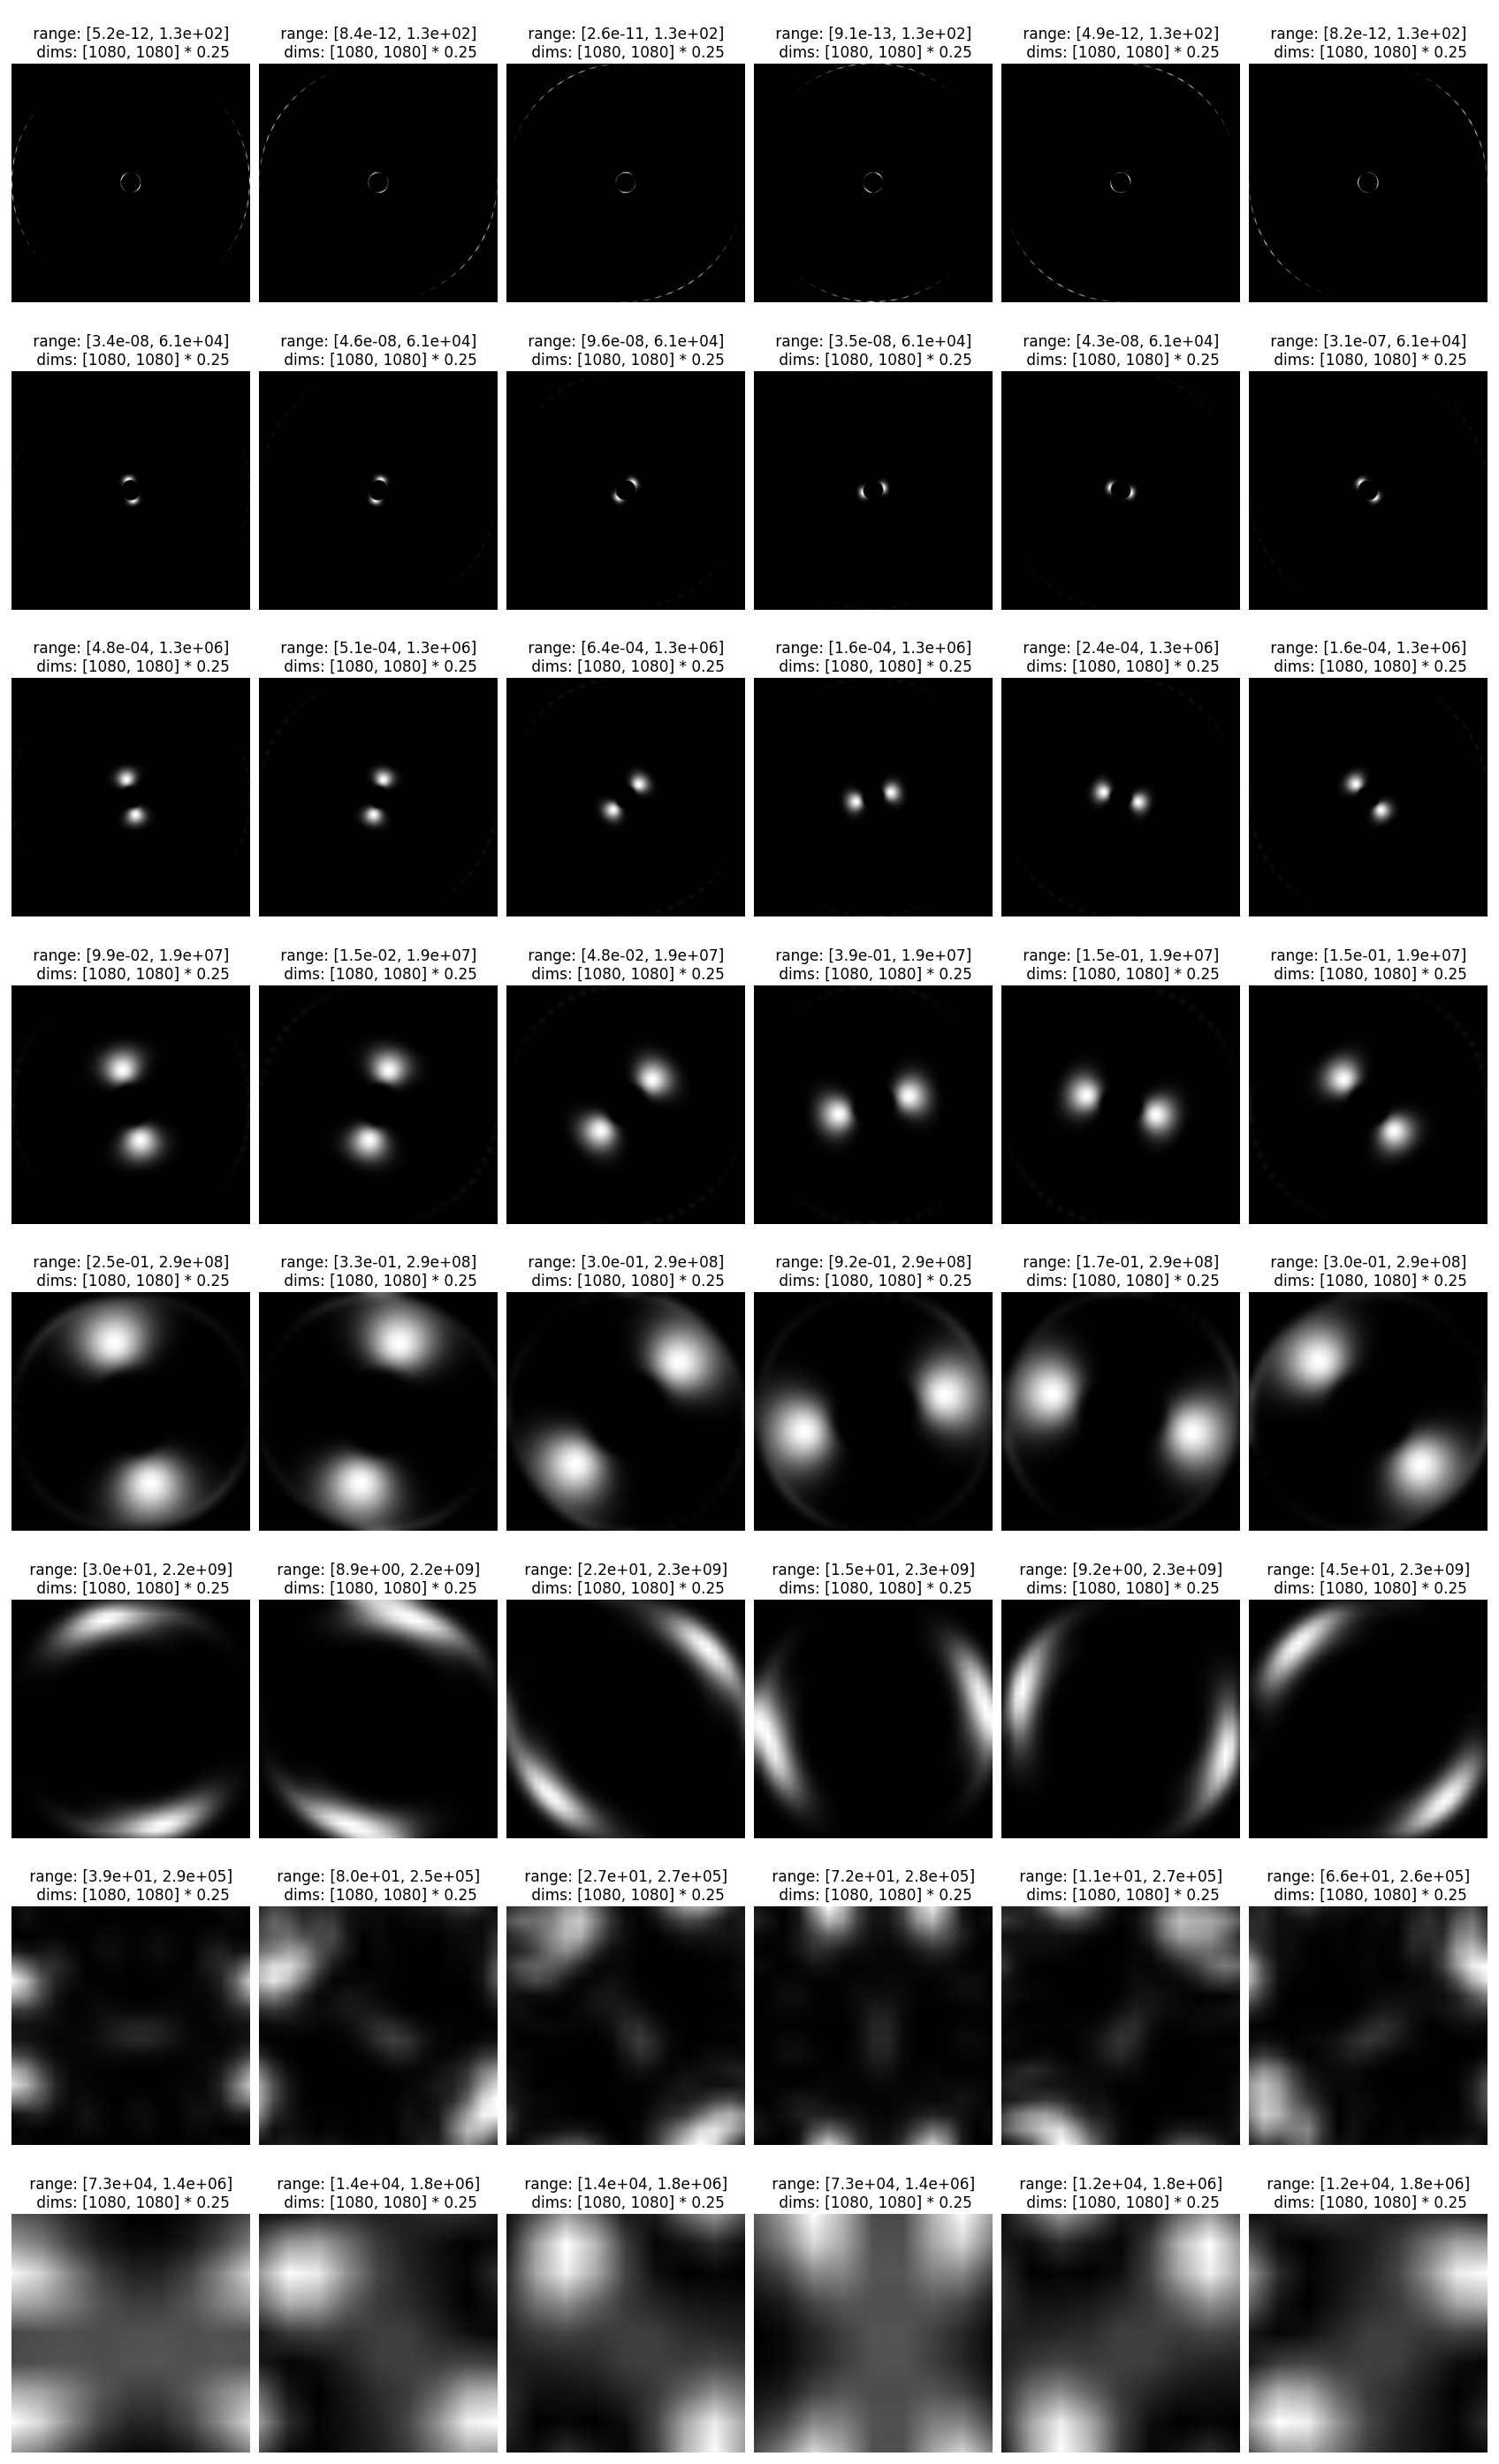

In [3]:
pt.imshow([energy[-1,i,j,:,:] for i in range(8) for j in range(6)], col_wrap=6, zoom=.25);

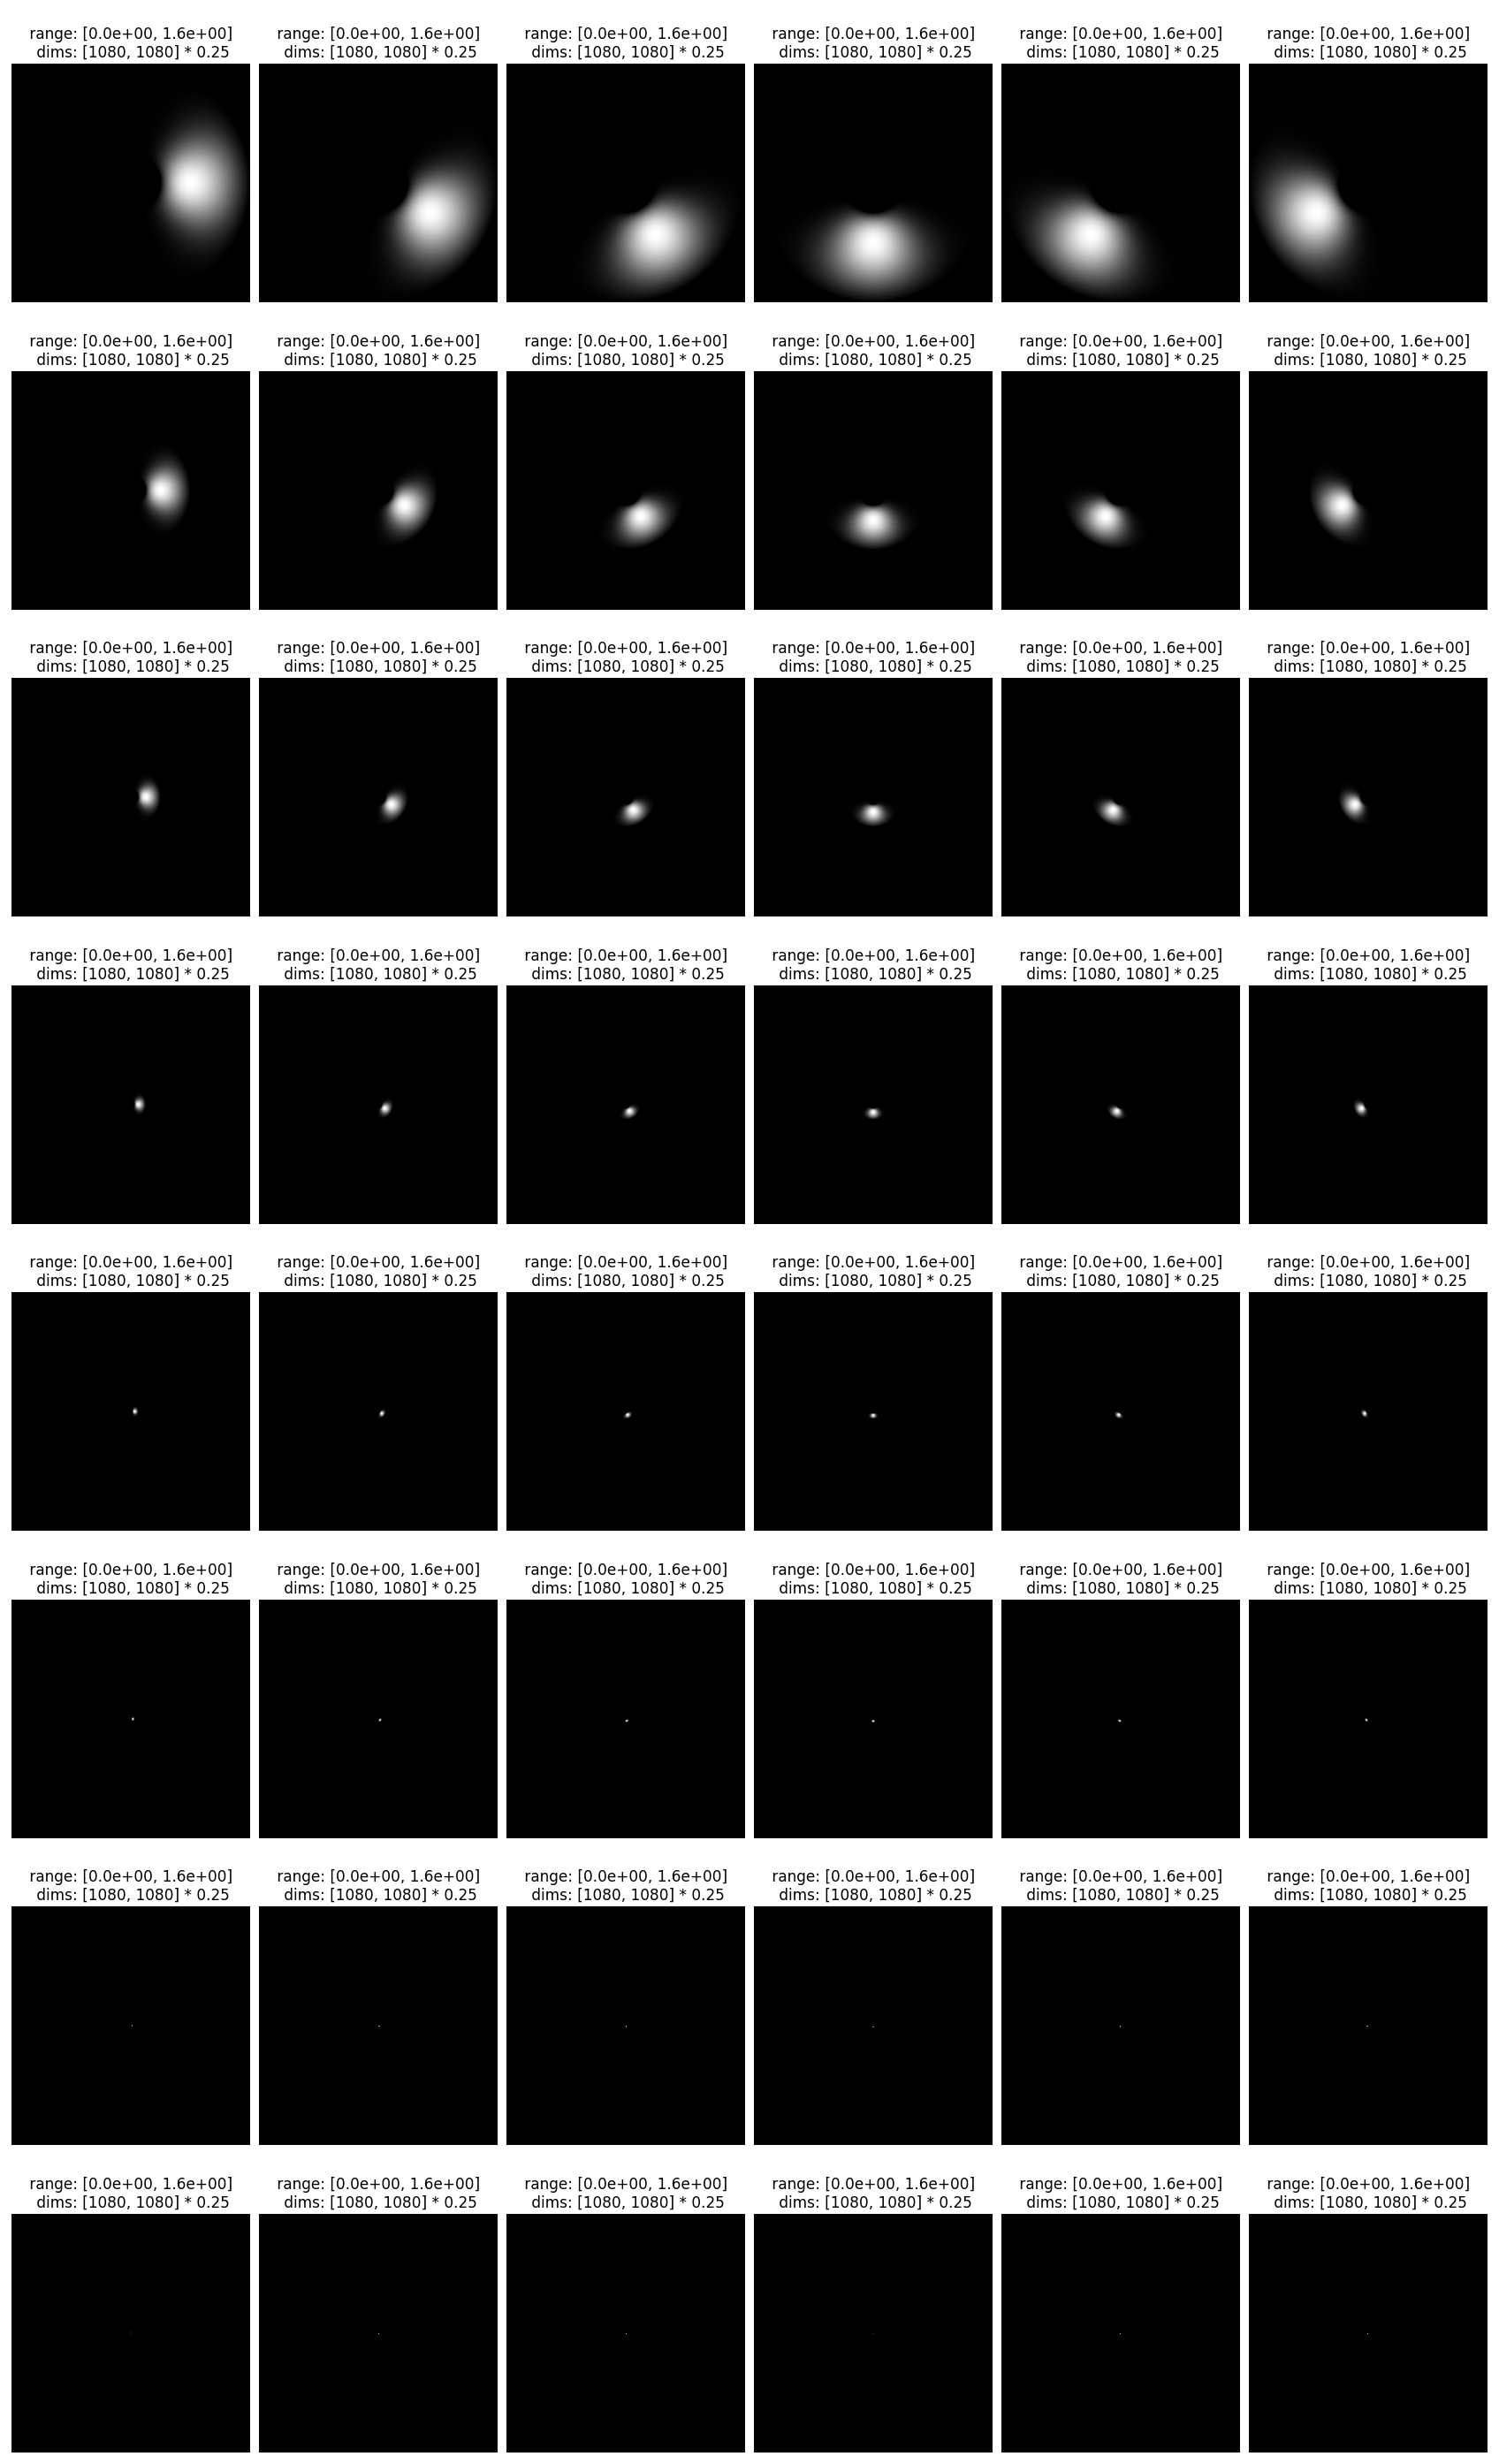

In [4]:
pt.imshow([filters[i,j,:,:] for i in range(8) for j in range(6)], col_wrap=6, zoom=.25);

Let's show that things work: let's take the data for one subject and show that the model can produce predictions for a given voxel in both image-computable and tuning curve modes

In [5]:
ds = sfp.model.FirstLevelDataset(df_path, device, model_mode='image-computable',)
dl = torchdata.DataLoader(ds, 3)

In order to run the image-computable mode, we need to pass the model the pre-computed energy and filters above

In [6]:
model = sfp.model.LogGaussianDonut(vary_amplitude=False, sigma=1, sf_ecc_intercept=.2, sf_ecc_slope=.3)
model.prepare_image_computable(energy, filters)

We then pass the model a tensor that contains the index into the stimulus class, the voxels' pRF location (in eccentricity and angle) and its sigma, for 3 different voxels

In [7]:
inputs, targets = next(iter(dl))

In [11]:
inputs[:,:5]

tensor([[[0.0000, 3.3923, 1.5379, 0.5945],
         [1.0000, 3.3923, 1.5379, 0.5945],
         [2.0000, 3.3923, 1.5379, 0.5945],
         [3.0000, 3.3923, 1.5379, 0.5945],
         [4.0000, 3.3923, 1.5379, 0.5945]],

        [[0.0000, 2.7762, 1.5326, 0.4905],
         [1.0000, 2.7762, 1.5326, 0.4905],
         [2.0000, 2.7762, 1.5326, 0.4905],
         [3.0000, 2.7762, 1.5326, 0.4905],
         [4.0000, 2.7762, 1.5326, 0.4905]],

        [[0.0000, 3.1239, 1.5550, 0.5492],
         [1.0000, 3.1239, 1.5550, 0.5492],
         [2.0000, 3.1239, 1.5550, 0.5492],
         [3.0000, 3.1239, 1.5550, 0.5492],
         [4.0000, 3.1239, 1.5550, 0.5492]]])

And we see the model produces a prediction for each of the 3 voxels for each of the 48 stimulus classes

In [8]:
model.image_computable(inputs)

tensor([[6.1728e+17, 3.8758e+17, 2.0870e+17, 7.9827e+16, 3.2646e+16, 9.0294e+15,
         3.1169e+15, 5.6713e+14, 1.2244e+14, 2.1880e+13, 7.1134e+17, 5.4744e+17,
         2.3957e+17, 1.0158e+17, 3.5182e+16, 1.0500e+16, 3.4506e+15, 6.5559e+14,
         1.3944e+14, 2.1608e+13, 7.1951e+17, 3.7637e+17, 1.9561e+17, 9.0586e+16,
         3.4354e+16, 8.8772e+15, 3.1077e+15, 5.9607e+14, 1.2714e+14, 2.1308e+13,
         8.1133e+17, 4.1678e+17, 2.1434e+17, 9.5383e+16, 3.5316e+16, 8.9741e+15,
         3.1075e+15, 5.9382e+14, 1.2598e+14, 2.1119e+13, 9.0469e+15, 8.9473e+15,
         9.4351e+15, 1.0016e+16, 1.0093e+16, 9.5270e+15, 9.0348e+15, 9.0979e+15],
        [3.1142e+17, 1.9307e+17, 9.7910e+16, 4.2768e+16, 1.4517e+16, 4.8640e+15,
         1.4974e+15, 2.6563e+14, 6.7331e+13, 9.3744e+12, 3.6496e+17, 2.8787e+17,
         1.1155e+17, 5.3053e+16, 1.6218e+16, 5.6065e+15, 1.6249e+15, 3.2712e+14,
         7.6775e+13, 9.7775e+12, 3.7868e+17, 1.8488e+17, 9.5330e+16, 4.7904e+16,
         1.5518e+16, 4.8654

We can also produce a prediction for a single voxel:

In [12]:
inputs, targets = ds[2]

In [13]:
model.image_computable(inputs)

tensor([[4.6902e+17, 2.9469e+17, 1.5308e+17, 6.2007e+16, 2.3638e+16, 6.8475e+15,
         2.3741e+15, 3.9701e+14, 9.9094e+13, 1.4926e+13, 5.4048e+17, 4.2410e+17,
         1.7225e+17, 7.9123e+16, 2.5544e+16, 8.0272e+15, 2.5850e+15, 4.7506e+14,
         1.1187e+14, 1.5022e+13, 5.5477e+17, 2.8384e+17, 1.4450e+17, 7.0273e+16,
         2.4878e+16, 6.8561e+15, 2.3394e+15, 4.2100e+14, 1.0249e+14, 1.4626e+13,
         6.1754e+17, 3.1283e+17, 1.5700e+17, 7.3678e+16, 2.5562e+16, 6.9165e+15,
         2.3413e+15, 4.1928e+14, 1.0164e+14, 1.4501e+13, 6.8785e+15, 6.8590e+15,
         7.2610e+15, 7.7009e+15, 7.7523e+15, 7.3200e+15, 6.9094e+15, 6.9064e+15]],
       grad_fn=<SumBackward2>)

And just for a sanity check, we can still have the model work in the tuning-curve type way. The scale is completely different, but, since we're normalizing the predictions when computing the loss, this shouldn't matter.

In [14]:
ds = sfp.model.FirstLevelDataset(df_path, device, model_mode='tuning_curve',)
dl = torchdata.DataLoader(ds, 3)

In [15]:
inputs, targets = next(iter(dl))
model(inputs)

tensor([[0.3033, 0.5283, 0.7989, 0.9916, 0.9253, 0.6847, 0.3954, 0.1739, 0.0591,
         0.0163, 0.3033, 0.5283, 0.7989, 0.9916, 0.9253, 0.6847, 0.3954, 0.1739,
         0.0591, 0.0163, 0.2651, 0.5795, 0.8202, 0.9856, 0.9337, 0.6706, 0.3910,
         0.1766, 0.0602, 0.0159, 0.2651, 0.5795, 0.8202, 0.9856, 0.9337, 0.6706,
         0.3910, 0.1766, 0.0602, 0.0159, 0.6843, 0.6780, 0.6780, 0.6843, 0.6843,
         0.6780, 0.6780, 0.6843],
        [0.3281, 0.5593, 0.8259, 0.9970, 0.9055, 0.6537, 0.3680, 0.1577, 0.0522,
         0.0140, 0.3281, 0.5593, 0.8259, 0.9970, 0.9055, 0.6537, 0.3680, 0.1577,
         0.0522, 0.0140, 0.2879, 0.6108, 0.8462, 0.9930, 0.9148, 0.6395, 0.3638,
         0.1602, 0.0532, 0.0137, 0.2879, 0.6108, 0.8462, 0.9930, 0.9148, 0.6395,
         0.3638, 0.1602, 0.0532, 0.0137, 0.6533, 0.6470, 0.6470, 0.6533, 0.6533,
         0.6470, 0.6470, 0.6533],
        [0.3129, 0.5404, 0.8096, 0.9940, 0.9178, 0.6726, 0.3846, 0.1674, 0.0564,
         0.0153, 0.3129, 0.5404, 0.8096, 

To step through what's happening here's, let's look at an imaginary voxel with the following properties:

In [17]:
vox_ecc = 4
vox_ang = 0
vox_sig = .5

First, based on its location in the visual field, we know its tuning, which we can show. This is the weight at each spatial frequency

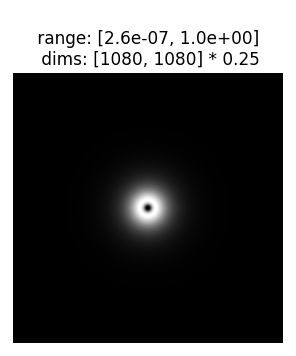

In [18]:
vox_tuning = model.create_image(vox_ecc, vox_ang)
pt.imshow(vox_tuning.detach(), zoom=.25);

Based on this tuning and filters we already passed the model, we can get the relative weights on each scale and orientation sub-band.

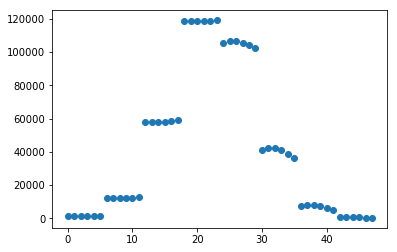

In [19]:
weights = model.image_computable_weights(vox_ecc, vox_ang)
plt.scatter(np.array(range(weights.nelement())), weights.detach())

With these weights, we take a weighted sum over the energy to get the feature map for this voxel.

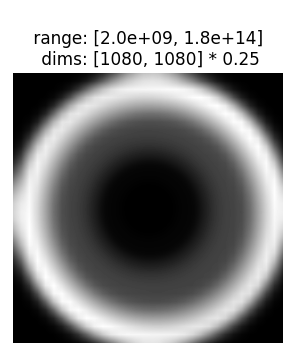

In [21]:
reweighted_energy = (weights * model.energy).sum((2, 3))
pt.imshow(reweighted_energy[0,5].detach(), zoom=.25);

And now we just create the pRF and drop it on the feature map.

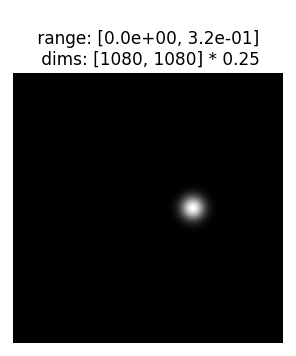

In [25]:
prf = model.create_prfs(vox_ecc, vox_ang, vox_sig)
pt.imshow(prf[0,0], zoom=.25);

And we have a prediction!

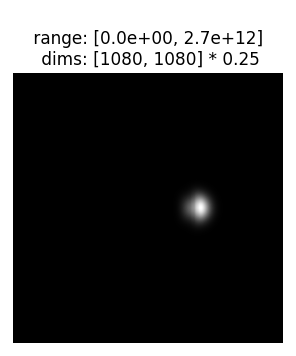

In [26]:
pt.imshow((prf * reweighted_energy).detach()[0,5], zoom=.25);

We actually sum across the entire pRF, as shown below.

In [27]:
(prf * reweighted_energy[0,5]).sum((-1,-2))

tensor([[1.6282e+16]], grad_fn=<SumBackward2>)

## Simple tests

Couple simple tests to make sure we're handling normalization correctly:

1. Given a uniform spatial frequency preference, a bunch of uniform gratings should all have the same prediction.

2. If we're normalizing the pRFs correctly, voxels that are identical except for their pRF size should have the same prediction.

In [ ]:
energy =

In [29]:
model = sfp.model.LogGaussianDonut(vary_amplitude=False, sigma=100)
model.

In [30]:
vox_ecc = 4
vox_ang = 0
vox_sig = .5

First, based on its location in the visual field, we know its tuning, which we can show. This is the weight at each spatial frequency

In [31]:
vox_tuning = model.create_image(vox_ecc, vox_ang)
pt.imshow(vox_tuning.detach(), zoom=.25);

AttributeError: 'LogGaussianDonut' object has no attribute 'stim_radius_degree'